**Energy Consumption Timeseries Model**

**Load Starting Packages**

**----**

**Load Dataset**


In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels as sm
import statistics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
#from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore")

df = pd.read_csv("EnergyConsumption_df.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')
df_W = df.resample("W").mean()
df_W.head()

,Total_MW
Datetime,
2012-01-01,46188.163043
2012-01-08,54688.875000
2012-01-15,55755.767857
2012-01-22,57336.458333
2012-01-29,53328.892857


<AxesSubplot:xlabel='Datetime'>

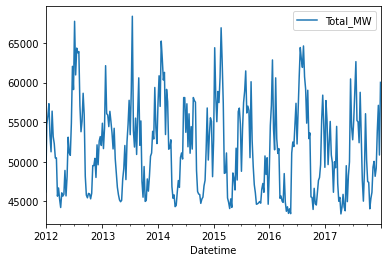

In [2]:
df_W.plot()

**Train | Test Datasets**

*6-years of data. Train: ~5-years; Test: ~1-year*

In [3]:
X = df_W.Total_MW
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

In [4]:
print("Train set: " + str(len(train)) + " weeks")

print("Test set: " + str(len(test)) + " weeks")

Train set: 251 weeks
Test set: 63 weeks


**Dicky-Fuller Test for "Stationarity"**

In [5]:
#dicky-fuller test...
adfuller_result = adfuller(X)
print('ADF Statistic: %f' % adfuller_result[0])
print('p-value: %f' % adfuller_result[1])
print('Critical Values:')
for key, val in adfuller_result[4].items():
    print('\t%s: %.3f' % (key, val))

ADF Statistic: -8.085169
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


*pvalue <0.05 & test-statistic < critica values*
*....*
*Support for "stationarity" in dataset*

In [6]:
from math import sqrt
from sklearn.metrics import mean_squared_error
#Persistence Model:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    #predict
    yhat = history[-1]
    predictions.append(yhat)
    #observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test, predictions))
print("rmse: %.3f" % rmse)

>Predicted=43980.946, Expected=46646
>Predicted=46646.137, Expected=44698
>Predicted=44698.006, Expected=44542
>Predicted=44541.836, Expected=46088
>Predicted=46087.673, Expected=47648
>Predicted=47647.619, Expected=48023
>Predicted=48022.976, Expected=49629
>Predicted=49629.393, Expected=55289
>Predicted=55289.208, Expected=58419
>Predicted=58418.899, Expected=54436
>Predicted=54435.958, Expected=49300
>Predicted=49299.982, Expected=57730
>Predicted=57730.220, Expected=55231
>Predicted=55231.435, Expected=49641
>Predicted=49641.423, Expected=52380
>Predicted=52380.220, Expected=55098
>Predicted=55097.673, Expected=50857
>Predicted=50857.173, Expected=49892
>Predicted=49892.060, Expected=46149
>Predicted=46148.762, Expected=50003
>Predicted=50003.262, Expected=49242
>Predicted=49242.334, Expected=54472
>Predicted=54472.232, Expected=47258
>Predicted=47257.786, Expected=45017
>Predicted=45016.780, Expected=45499
>Predicted=45498.649, Expected=43414
>Predicted=43414.054, Expected=44256
>

*The Persistence Model has rmse=4147. Can we improve this with different model types?*

**Plot PACF, ACF**

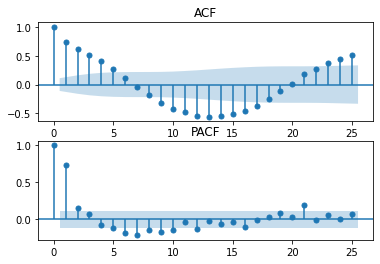

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure()
plt.subplot(211)
plot_acf(X, ax=plt.gca())
plt.title("ACF")
plt.subplot(212)
plot_pacf(X, ax=plt.gca())
plt.title("PACF")
plt.show()

**ARIMA Model**

In [8]:
#initial estimate of ARIMA Model
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    #predictions
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    #observations
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
#evaluation
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=43362.919, Expected=46646.137
>Predicted=45788.700, Expected=44698.006
>Predicted=44243.565, Expected=44541.836
>Predicted=44743.512, Expected=46087.673
>Predicted=45422.729, Expected=47647.619
>Predicted=47100.702, Expected=48022.976
>Predicted=47773.779, Expected=49629.393
>Predicted=49273.861, Expected=55289.208
>Predicted=53769.841, Expected=58418.899
>Predicted=57334.951, Expected=54435.958
>Predicted=55761.210, Expected=49299.982
>Predicted=51572.656, Expected=57730.220
>Predicted=56338.338, Expected=55231.435
>Predicted=54766.358, Expected=49641.423
>Predicted=51823.475, Expected=52380.220
>Predicted=52123.135, Expected=55097.673
>Predicted=53492.291, Expected=50857.173
>Predicted=51850.048, Expected=49892.060
>Predicted=50987.289, Expected=46148.762
>Predicted=47015.670, Expected=50003.262
>Predicted=49358.969, Expected=49242.334
>Predicted=48409.226, Expected=54472.232
>Predicted=53282.465, Expected=47257.786
>Predicted=48514.330, Expected=45016.780
>Predicted=47063

*Initial estimate of ARIMA parameters improves on the RMSE (3977) from the persistence model. This is a good start, and promising.*

**ARIMA Hyperparameter Grid Search**

*p-values, d-values, q-values*

*Can we obtain a lower RMSE (<3977)?*

In [9]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):

    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate RMSE
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
 
# evaluate (p,d,q) values for ARIMA
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

p_values = [1, 3, 5, 7]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(X, p_values, d_values, q_values)

ARIMA(1, 0, 0) RMSE=3815.883
ARIMA(1, 0, 1) RMSE=3794.032
ARIMA(1, 1, 0) RMSE=4054.446
ARIMA(1, 1, 1) RMSE=3974.575
ARIMA(3, 0, 0) RMSE=3789.645
ARIMA(3, 0, 1) RMSE=3826.792
ARIMA(3, 1, 0) RMSE=4008.279
ARIMA(3, 1, 1) RMSE=4006.468
ARIMA(5, 0, 0) RMSE=3847.058
ARIMA(5, 1, 0) RMSE=3973.090
ARIMA(5, 1, 1) RMSE=3974.567
ARIMA(7, 0, 0) RMSE=3655.228
ARIMA(7, 0, 1) RMSE=3619.369
ARIMA(7, 1, 0) RMSE=3978.956
ARIMA(7, 1, 1) RMSE=3667.999
Best ARIMA(7, 0, 1) RMSE=3619.369


*Evaluating various ARIMA hyperparameters, (p,d,q), shows the smallest RMSE (7,0,1): rmse=3619

*This reduces the rmse by > 300*

**Residual Errors from ARIMA**

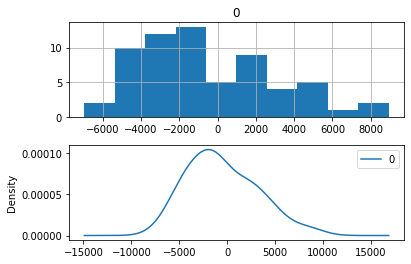

In [14]:
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    model = ARIMA(history, order=(7,0,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    #observations
    obs = test[i]
    history.append(obs)
        
#residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)

#plot residuals        
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

In [15]:
print(residuals.describe())

                 0
count    63.000000
mean   -494.278714
std    3614.124510
min   -6960.202002
25%   -3041.255935
50%   -1068.528049
75%    2094.000481
max    8934.719120


*There is a bias towards the left of 0 (-494). *bias by

*Correct bias in prediction values by adding this value to the forecast*

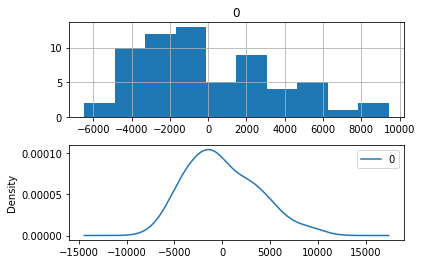

In [18]:
#residuals bias correction 
history = [x for x in train]
predictions = list()
bias = -494
for i in range(len(test)):
    model = ARIMA(history, order=(7,0,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    yhat = bias + yhat
    predictions.append(yhat)
    #observations
    obs = test[i]
    history.append(obs)
        
#residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)

#plot residuals        
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

In [19]:
#summary stats of bias-corrected residuals
print(residuals.describe())

                 0
count    63.000000
mean     -0.214839
std    3613.921259
min   -6467.374332
25%   -2547.142596
50%    -574.500755
75%    2587.554809
max    9426.736043


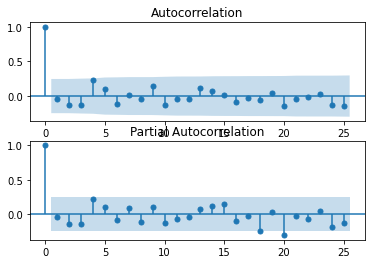

In [20]:
#plot re-calculated acf, pacf
plt.figure()
plt.subplot(211)
plot_acf(residuals, lags=25, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, lags=25, ax=plt.gca())
plt.show()

*The autocorrelation has been captured in ARIMA Model; no autocorrelation in residuals*

**Validate the ARIMA Model**

In [23]:
import numpy as np
model_fit.save('ARIMA_model.pkl')
np.save('model_bias.npy',[bias])

>Predicted=52888.772, Expected=46646.137
>Predicted=48164.833, Expected=44698.008
>Predicted=45162.105, Expected=44541.836
>Predicted=43930.128, Expected=46087.672
>Predicted=44433.322, Expected=47647.617
>Predicted=45383.281, Expected=48022.977
>Predicted=47024.221, Expected=49629.395
>Predicted=48358.599, Expected=55289.207
>Predicted=52948.845, Expected=58418.898
>Predicted=56217.210, Expected=54435.957
>Predicted=54580.693, Expected=49299.980
>Predicted=51153.984, Expected=57730.219
>Predicted=56221.869, Expected=55231.434
>Predicted=54439.650, Expected=49641.422
>Predicted=50379.063, Expected=52380.219
>Predicted=51819.099, Expected=55097.672
>Predicted=53660.009, Expected=50857.172
>Predicted=50879.977, Expected=49892.059
>Predicted=49799.476, Expected=46148.762
>Predicted=47121.117, Expected=50003.262
>Predicted=48963.570, Expected=49242.332
>Predicted=47984.038, Expected=54472.230
>Predicted=51795.120, Expected=47257.785
>Predicted=48014.009, Expected=45016.781
>Predicted=46221

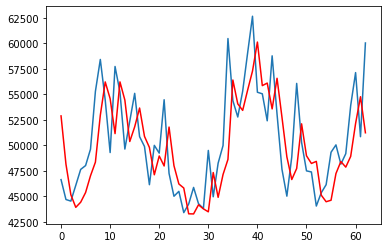

In [41]:
from statsmodels.tsa.arima_model import ARIMAResults
# load model

validation = test
y = validation.values.astype('float32')

model_fit = ARIMAResults.load('ARIMA_model.pkl')
bias = np.load('model_bias.npy')

#predictions
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + yhat
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

#forecast
for i in range(1,len(y)):
    model = ARIMA(history, order=(7,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + yhat
    predictions.append(yhat)
    
    #observations
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
plt.plot(y)
plt.plot(predictions, color='red')
plt.show()

**Prophet Timeseries Model**

In [ ]:
model_prophet = Prophet()
model.fit(X)

In [ ]:
# load and evaluate the finalized model on the validation dataset
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True,squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year) predictions.append(yhat)
history.append(y[0])
print('>Forecast=%.3f, Actual=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(1,1,0))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = bias + inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  # observation
  obs = y[i]
  history.append(obs)
  print('>Forecast=%.3f, Actual=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

**Random Forest Model Forecasting Energy Consumption**

*supervised learning model*

*Will this model improve on the ARIMA model?*

In [54]:
df_W.head()
df_reset = df_W.reset_index()

In [55]:
df_reset.head()

,Datetime,Total_MW
0,2012-01-01,46188.163043
1,2012-01-08,54688.875000
2,2012-01-15,55755.767857
3,2012-01-22,57336.458333
4,2012-01-29,53328.892857


In [57]:
df_reset['week'] = pd.to_datetime(df_reset['Datetime'], errors='coerce')

In [59]:
df_weeks = df_reset[['week', 'Total_MW']]

In [60]:
#convert datetime to integar values (non-indexed)

df_weeks['week'].astype('int64').dtypes

dtype('int64')

In [63]:
df_weeks['weekNum'] = df_weeks['week'].dt.week

In [70]:
df_weeks.shape

(314, 3)

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    
    #input sequence...
    for i in range(n_in, 0,1):
        cols.append(df.shift(i))
    
    #forecast squence...
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

def train_test_split(data, n_test):
    return data[:-n_test,:], data[-n_test:,:]

def random_forest_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:,:-1], train[:,-1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    #error = mean_absolute_error(test[:, -1], predictions)
	rmse = sqrt(mean_squared_error(test[:, -1], predictions))
	return rmse, test[:, -1], predictions


In [74]:
df1 = df_weeks[['weekNum','Total_MW']]

>expected=57730.2, predicted=54850.9
>expected=55231.4, predicted=57918.0
>expected=49641.4, predicted=57961.8
>expected=52380.2, predicted=57948.6
>expected=55097.7, predicted=56190.0
>expected=50857.2, predicted=58139.6
>expected=49892.1, predicted=56441.3
>expected=46148.8, predicted=56151.3
>expected=50003.3, predicted=55745.9
>expected=49242.3, predicted=52928.4
>expected=54472.2, predicted=48597.6
>expected=47257.8, predicted=49226.1
>expected=45016.8, predicted=48895.5
>expected=45498.6, predicted=46743.5
>expected=43414.1, predicted=45606.4
>expected=44255.7, predicted=45033.5
>expected=45883.1, predicted=45025.3
>expected=44290.2, predicted=45208.6
>expected=43809.9, predicted=45927.2
>expected=49504.8, predicted=46976.5
>expected=44967.1, predicted=49325.8
>expected=48259.0, predicted=51582.1
>expected=49987.1, predicted=49827.2
>expected=60468.1, predicted=53747.3
>expected=54386.2, predicted=57795.8
>expected=52781.0, predicted=56387.7
>expected=55310.3, predicted=56120.6
>

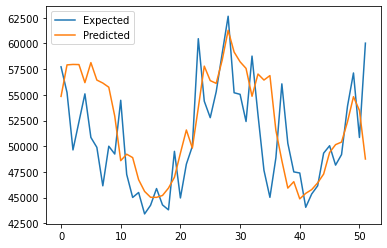

In [91]:
values = df1.values

data = series_to_supervised(values, n_in=6)

rmse, y, yhat = walk_forward_validation(data, 52)
print('RMSE: %.3f' % rmse)
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

*The initial Random Forest Regression Model suggests slightly more error (rmse) within the model prediction*